In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# obtain data
local_df = pd.read_csv('data/train.csv', index_col=0)
competition_df = pd.read_csv('data/test.csv', index_col=0)

# remove salesprice from local_df
y_local = local_df.loc[:, 'SalePrice']
local_df = local_df.drop('SalePrice', axis=1)

# combine data sets and then impute
local_df = pd.get_dummies(local_df, drop_first=True)
competition_df = pd.get_dummies(competition_df, drop_first=True)
X_all = pd.concat([local_df, competition_df])
X_all = X_all.fillna(X_all.mean())

# obtain highly correlated features from train df
features = local_df.corrwith(y_local).abs().sort_values(ascending=False).iloc[:].index.values

# constrain to highly correlated features
X_all = X_all.loc[:, features]

# split data into oringal sets
X_local = X_all.iloc[:1460]
X_competition = X_all.iloc[1460:]

# convert dataframes/series to ndarrays
X_local = X_local.values
y_local = y_local.values

# perform log transformation on y_values
y_local = np.log(y_local)

# print shapes
print(X_all.shape, X_local.shape, y_local.shape, X_competition.shape)

(2919, 245) (1460, 245) (1460,) (1459, 245)


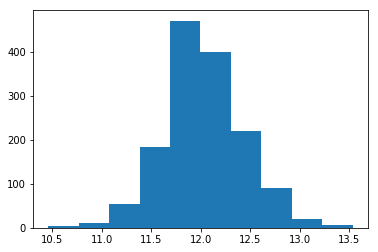

In [34]:
import matplotlib.pyplot as plt

local_df = pd.read_csv('data/train.csv', index_col=0)

def plot_histogram(df, feature_name):
    ys = df.loc[:, feature_name]
    plt.hist(np.log(ys), 10)
    plt.show()
    
plot_histogram(local_df, "SalePrice")

In [35]:
from sklearn.metrics import make_scorer

def rmsle(y, y_pred):
    y_pred[y_pred <= 0] = 1
    
    return np.sqrt(mean_squared_error(np.log(y+1), np.log(y_pred+1)))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [39]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.svm import LinearSVR

# split to train/test
X_train,X_test,y_train,y_test = train_test_split(X_local, y_local, test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1022, 245) (438, 245) (1022,) (438,)


In [40]:
base_model = SVR()
pipeline = Pipeline([('standardizer', StandardScaler()), ('base_model', base_model)])
print(pipeline.get_params().keys())

params = { 'base_model__C': [1] }
model = GridSearchCV(pipeline, params) 
model.fit(X_train, y_train)

print(model.best_estimator_.named_steps['base_model'])

y_test_pred = model.predict(X_test)
print(type(y_test_pred), type(y_test))

rmse_logs = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(rmse_logs)

dict_keys(['base_model__epsilon', 'standardizer__copy', 'base_model__tol', 'steps', 'base_model__verbose', 'base_model__max_iter', 'base_model__degree', 'base_model__gamma', 'base_model__shrinking', 'standardizer__with_std', 'base_model', 'base_model__cache_size', 'base_model__kernel', 'standardizer__with_mean', 'base_model__C', 'base_model__coef0', 'standardizer'])
SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
0.177538052393


In [31]:
from sklearn.tree import export_graphviz

params = {}
base_model = DecisionTreeRegressor(min_samples_leaf=3)
ensemble_model = GradientBoostingRegressor(n_estimators=100)

model = GridSearchCV(ensemble_model, params, scoring=rmsle_scorer)
model.fit(X_train, y_train)

#print(model.best_estimator_.estimators_)

y_test_pred = model.predict(X_test)
print(type(y_test_pred), type(y_test))

rmse_logs = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_test_pred)))
print(rmse_logs)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
0.146338087681


[-0.10116482 -0.08571823 -0.07617305 -0.07684439 -0.07680183 -0.07623315
 -0.07580894 -0.07675636 -0.07533192 -0.07049035]
[-0.19732366 -0.18089582 -0.17510611 -0.16959578 -0.16727422 -0.16234932
 -0.16375624 -0.16066616 -0.15900025 -0.16005677]
{}


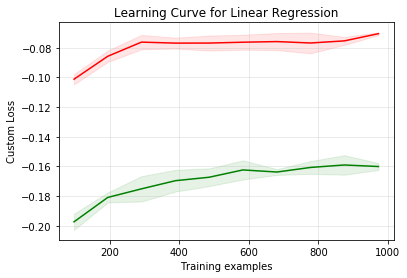

In [38]:
from sklearn.model_selection import learning_curve

lc_x, lc_train, lc_test = learning_curve(model, X_local, y_local, cv=3,
                                        scoring=rmsle_scorer, train_sizes=np.linspace(0.1,1,10))
lc_train_mean = np.mean(lc_train, axis=1)
lc_train_std = np.std(lc_train, axis=1)
lc_test_mean = np.mean(lc_test, axis=1)
lc_test_std = np.std(lc_test, axis=1)

print(lc_train_mean)
print(lc_test_mean)

print(model.best_params_)

plt.title('Learning Curve for Linear Regression')
plt.ylabel('Custom Loss')
plt.xlabel('Training examples')
plt.grid(alpha=0.3)

plt.fill_between(lc_x, lc_train_mean - lc_train_std, lc_train_mean + lc_train_std, alpha=0.1, color='r')
plt.fill_between(lc_x, lc_test_mean - lc_test_std, lc_test_mean + lc_test_std, alpha=0.1, color='g')
plt.plot(lc_x, lc_train_mean, 'r-', lc_x, lc_test_mean, 'g-')
plt.show()

In [12]:
y_competition_pred = model.predict(X_competition)
y_competition_pred = np.exp(y_competition_pred)
y_competition_pred[y_competition_pred < 0] = 100000
print(type(y_competition_pred), type(X_competition))
print(X_competition.shape, y_competition_pred.shape)

print(X_competition.index[-1])

out = open('data/predictions.csv', 'w')
out.write('Id,SalePrice\n')

for i in range(len(y_competition_pred)):
    out.write('%d,%f\n' % (X_competition.index[i], y_competition_pred[i]))

out.close()

<class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>
(1459, 125) (1459,)
2919
